In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# MSBA 6330 - Homework 6 - Spark RDD and SQL - Danny Moncada

This homework corresponds to the Spark RDD and Spark SQL modules. It has two parts, A & B, corrsponding to spark RDD and Spark SQL respectively. 

We use two dataset

- `2013-09-15.log`: one day worth of web log 
- `yelp.json` (Yelp academic dataset, https://www.yelp.com/dataset/challenge. they've different rounds with different datasets. In this one, they've selected yelp businesses near universities). 

This homework corresponds to the Spark RDD and Spark SQL modules. It has two parts, A & B, corrsponding to spark RDD and Spark SQL respectively. 

You can use `wget` (from Linux/bash shell) or browser to download the dataset to your localhost where your spark notebooks are.

**note**: as the `yelp.zip` is too big to be uploaded from a browser (the max is 25MB), you can use the wget approach. To use wget from jupyter notebook, use New > Terminal, then you have access to bash terminal, where you can run shell commands.

**note2**: if you encounter an error, `The root scratch dir: /tmp/hive on HDFS should be writable`. Open a terminal and run the following comamnd: `sudo chmod 777 /tmp/hive`. 

**note3**: If at any point you see this error, `AnalysisException: u'java.lang.RuntimeException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient;`. Please close terminate all other running jupyter notebooks (from your jupyter home, go to Running tab, then terminate). If that does not work still, try to restart the kernerl (from your current jupyter notebook's menu, kernel > restart). 

## Part A. RDD

In this part, we use Spark RDD to parse and analyze a weblog file that we have seen before (at `/home/cloudera/training_materials/data/weblogs/` on your cloudera VM). We have provided a single log file `2013-09-15.log"` for the purpose of this homework. 

### First, you should inspect the data file to be familar with its format 

1\. view the first 5 row of the log file

__DM: I am using the experimental VM with Spark & Scala, so I just saved the file in the same location as my IPNB files__

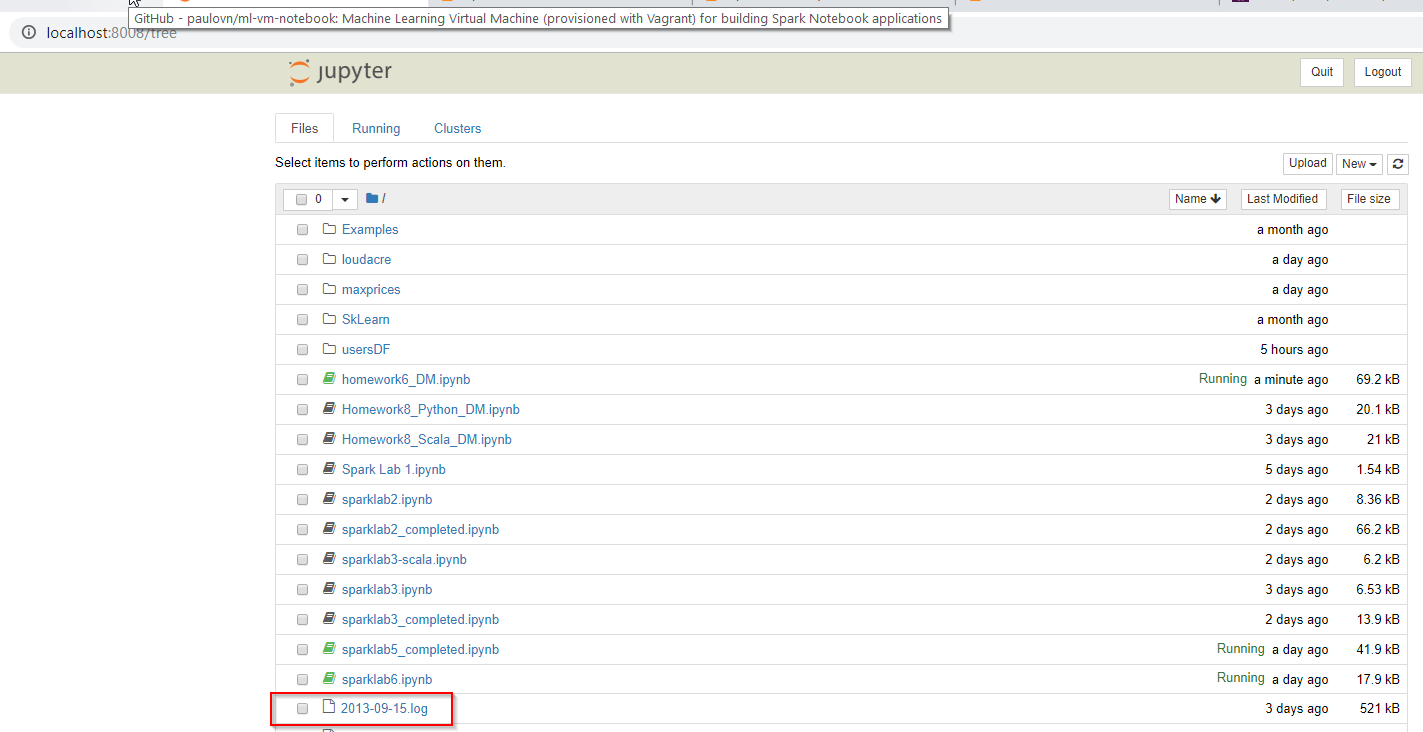

In [2]:
! head -5 2013*

3.94.78.5 - 69827 [15/Sep/2013:23:58:36 +0100] "GET /KBDOC-00033.html HTTP/1.0" 200 14417 "http://www.loudacre.com"  "Loudacre Mobile Browser iFruit 1"
3.94.78.5 - 69827 [15/Sep/2013:23:58:36 +0100] "GET /theme.css HTTP/1.0" 200 3576 "http://www.loudacre.com"  "Loudacre Mobile Browser iFruit 1"
19.38.140.62 - 21475 [15/Sep/2013:23:58:34 +0100] "GET /KBDOC-00277.html HTTP/1.0" 200 15517 "http://www.loudacre.com"  "Loudacre Mobile Browser Ronin S1"
19.38.140.62 - 21475 [15/Sep/2013:23:58:34 +0100] "GET /theme.css HTTP/1.0" 200 13353 "http://www.loudacre.com"  "Loudacre Mobile Browser Ronin S1"
129.133.56.105 - 2489 [15/Sep/2013:23:58:34 +0100] "GET /KBDOC-00033.html HTTP/1.0" 200 10590 "http://www.loudacre.com"  "Loudacre Mobile Browser Sorrento F00L"


### Load and parse rows

Parse the log file requires some regular expression skills. Try to read and understand regular expression pattern used in the following function.

In this function, we also create a Row (defined in PySpark SQL) out of the matched values. One advantage of the **Row** over a **tuple** is that you can reference a field by name. 

2\. Review the parsing function

In [3]:
from pyspark.sql import Row  # Row class
import re  # regular expression package

def parse_log_line(line):
    pattern = '^([\d.]+) - (\d+) \[(.+?)\] \"(.+?)\" (\d{3}) (\d+) \"(.+?)\"  \"(.+)\"';
    try:
        match = re.search(pattern,line)
        # after matching, you can access the captured values using .group(n), where n is the n-th captured value.
        return Row(ip=match.group(1), \
                   userid=int(match.group(2)), \
                   timestamp = match.group(3), \
                   request = match.group(4), \
                   status = int(match.group(5)), \
                   length = int(match.group(6)), \
                   referer = match.group(7), \
                   device = match.group(8))
    except:
        pass  # if we encounter error, we skip this line.

3\. Using the above shared function to construct a new `RDD[Row]` named `logs`, then **cache** it

In [4]:
logfile = "2013*"

In [5]:
logs = sc.textFile(logfile) \
    .map(lambda line: parse_log_line(line)) \
    .cache()

In [6]:
logs.take(5)

[Row(device='Loudacre Mobile Browser iFruit 1', ip='3.94.78.5', length=14417, referer='http://www.loudacre.com', request='GET /KBDOC-00033.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:36 +0100', userid=69827),
 Row(device='Loudacre Mobile Browser iFruit 1', ip='3.94.78.5', length=3576, referer='http://www.loudacre.com', request='GET /theme.css HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:36 +0100', userid=69827),
 Row(device='Loudacre Mobile Browser Ronin S1', ip='19.38.140.62', length=15517, referer='http://www.loudacre.com', request='GET /KBDOC-00277.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:34 +0100', userid=21475),
 Row(device='Loudacre Mobile Browser Ronin S1', ip='19.38.140.62', length=13353, referer='http://www.loudacre.com', request='GET /theme.css HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:34 +0100', userid=21475),
 Row(device='Loudacre Mobile Browser Sorrento F00L', ip='129.133.56.105', length=10590, referer='http://www.loudacre.com'

4\. Use `logs` to calculate total bytes transmitted, noting that bytes transmitted in a single request is `length`.

In [7]:
total_bytes = logs.map(lambda r: r[2]).sum()

print()
print("The total bytes transmitted is {} bytes.".format(total_bytes))


The total bytes transmitted is 34829899 bytes.


5\. The status code is standard HTTP code indicating how your a request for a page from a server went. Any status code that is 300+ indicates some problems (e.g. forbidden access, page moved, server no response, etc). One purpose of log analysis is to find out if the requests frequently encounter problems.

Specifically, what are the distinct status code recorded in this log file?

In [8]:
print()
print("The distinct status codes recorded in the log file are {}.".format(logs.map(lambda r: r[5]).distinct().collect()))


The distinct status codes recorded in the log file are [200].


### Extract KBDOC ids

The log can be linked with other data soures to understand users' visiting behavior. 

In the following, we ask you to extract visits to Knowledge base documents (KBDOC). 

6\. For each request for KBDOC, list `userid` and the KBDOC id (e.g. `/KBDOC-00107`), with the results ordered by `userid`. 

In [9]:
## filter on "KBDOC" existing in the request column
kbdoc = logs.filter(lambda r: "KBDOC" in r[4])

In [10]:
## show first five rows to make sure we're only getting KBDOC requests back
kbdoc.take(5)

[Row(device='Loudacre Mobile Browser iFruit 1', ip='3.94.78.5', length=14417, referer='http://www.loudacre.com', request='GET /KBDOC-00033.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:36 +0100', userid=69827),
 Row(device='Loudacre Mobile Browser Ronin S1', ip='19.38.140.62', length=15517, referer='http://www.loudacre.com', request='GET /KBDOC-00277.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:34 +0100', userid=21475),
 Row(device='Loudacre Mobile Browser Sorrento F00L', ip='129.133.56.105', length=10590, referer='http://www.loudacre.com', request='GET /KBDOC-00033.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:58:34 +0100', userid=2489),
 Row(device='Loudacre Mobile Browser Sorrento F11L', ip='209.151.12.34', length=19362, referer='http://www.loudacre.com', request='GET /KBDOC-00259.html HTTP/1.0', status=200, timestamp='15/Sep/2013:23:55:09 +0100', userid=45922),
 Row(device='Loudacre CSR Browser', ip='184.97.84.245', length=12499, referer='http://www.l

In [11]:
## define a function to get the user_id (8th column), and then split the request (5th column) TWICE to get the KBDOC id by istelf and return these values.
## Cleaner to build a simple function and then just map that to the DataFrame.

def kbdoc_func(line):
    return line[7], line[4].split(" ")[1].split(".html")[0]

In [12]:
requests = kbdoc.map(lambda r: kbdoc_func(r))

In [13]:
## print the total number of rows for the DF

## Sort the results by user id and rename the columns so they look more presentable
## I only show the first twenty for readability, there are 1275 total.

print("Total number of {} rows.".format(requests.toDF().count()))
print()

requests.sortByKey().toDF().withColumnRenamed("_1","userid").withColumnRenamed("_2", "KBDOC_id").show()

Total number of 1275 rows.

+------+------------+
|userid|    KBDOC_id|
+------+------------+
|     1|/KBDOC-00107|
|     2|/KBDOC-00058|
|     2|/KBDOC-00161|
|     3|/KBDOC-00199|
|     3|/KBDOC-00269|
|     5|/KBDOC-00218|
|     5|/KBDOC-00135|
|     5|/KBDOC-00198|
|     7|/KBDOC-00008|
|     8|/KBDOC-00232|
|     9|/KBDOC-00101|
|     9|/KBDOC-00023|
|     9|/KBDOC-00130|
|     9|/KBDOC-00057|
|    11|/KBDOC-00089|
|    11|/KBDOC-00284|
|    12|/KBDOC-00263|
|    12|/KBDOC-00206|
|    13|/KBDOC-00193|
|    14|/KBDOC-00286|
+------+------------+
only showing top 20 rows



## Part B. Spark DataFrame/SQL

7\. Create a Spark dataframe from the file source yelp.json

In [14]:
## check the structure of the file - yep, definitely in JSON format!  This should be fun.

! head -5 yelp.json

{"votes": {"funny": 15, "useful": 48, "cool": 18}, "user_id": "JkeCKyEaQlbLd9uZYl4DjA", "name": "LiiLii C.", "url": "http://www.yelp.com/user_details?userid=JkeCKyEaQlbLd9uZYl4DjA", "average_stars": 3.2258064516128999, "review_count": 31, "type": "user"}
{"votes": {"funny": 0, "useful": 2, "cool": 0}, "user_id": "cs91PAsv6esdWAaSkzm2lg", "name": "Jan Ellen T.", "url": "http://www.yelp.com/user_details?userid=cs91PAsv6esdWAaSkzm2lg", "average_stars": 3.0, "review_count": 4, "type": "user"}
{"votes": {"funny": 8, "useful": 19, "cool": 10}, "user_id": "cMgGj2FXHEbzdNZdLN_EwA", "name": "Saki U.", "url": "http://www.yelp.com/user_details?userid=cMgGj2FXHEbzdNZdLN_EwA", "average_stars": 3.60606060606061, "review_count": 33, "type": "user"}
{"votes": {"funny": 61, "useful": 119, "cool": 78}, "user_id": "KXJbnHT4PDS1JZNCFKdmMg", "name": "stephanie h.", "url": "http://www.yelp.com/user_details?userid=KXJbnHT4PDS1JZNCFKdmMg", "average_stars": 3.3030303030303001, "review_count": 33, "type": "user

In [15]:
## Read in the file, and cache the DF for faster reading

yelpDF = spark.read.json("yelp.json")
yelpDF.cache()

DataFrame[average_stars: double, business_id: string, categories: array<string>, city: string, date: string, full_address: string, latitude: double, longitude: double, name: string, neighborhoods: array<string>, open: boolean, photo_url: string, review_count: bigint, review_id: string, schools: array<string>, stars: double, state: string, text: string, type: string, url: string, user_id: string, votes: struct<cool:bigint,funny:bigint,useful:bigint>]

8\. Examine the schema of the dataframe that you've just created and inspect the first 5 rows. Use these to answer the following questions:

**Question**:  Are all fields simple fields? If not, what are the "complex" fields? What types of values do they hold? Give an example of each in the data (use query to get examples if needed). 

In [16]:
## inspect the first 5 rows

yelpDF.show(5)

+----------------+-----------+----------+----+----+------------+--------+---------+------------+-------------+----+---------+------------+---------+-------+-----+-----+----+----+--------------------+--------------------+-------------+
|   average_stars|business_id|categories|city|date|full_address|latitude|longitude|        name|neighborhoods|open|photo_url|review_count|review_id|schools|stars|state|text|type|                 url|             user_id|        votes|
+----------------+-----------+----------+----+----+------------+--------+---------+------------+-------------+----+---------+------------+---------+-------+-----+-----+----+----+--------------------+--------------------+-------------+
| 3.2258064516129|       null|      null|null|null|        null|    null|     null|   LiiLii C.|         null|null|     null|          31|     null|   null| null| null|null|user|http://www.yelp.c...|JkeCKyEaQlbLd9uZY...| [18, 15, 48]|
|             3.0|       null|      null|null|null|        n

In [17]:
## Show the schema, and we see there's lots of interesting stuff to unpack!

yelpDF.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- full_address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhoods: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- open: boolean (nullable = true)
 |-- photo_url: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- schools: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- votes: struct (nullab

### **Answer**:  

### No, not all the columns are "simple" fields.  Specifically, there are three columns, *categories*, *neighborhoods*, & *schools* that are ArrayType.
*  *categories* contains a list of categories associated with the review
*  *neighborhoods* contains a list of neighborhoods where the business is located
*  *schools* contains a list of schools near the business

### In addition, there is the *votes* column that is StructType.

*  This contains what looks like a dictionary with values for *cool*, *funny*, and *useful*. Let's print a few to see!


In [18]:
yelpDF.select("categories").distinct().show(10, truncate = False)

+------------------------------------------------------------------------+
|categories                                                              |
+------------------------------------------------------------------------+
|[American (New), Mediterranean, Asian Fusion, Restaurants]              |
|[Food, Arts & Entertainment, Wineries]                                  |
|[Gastropubs, Arts & Entertainment, Nightlife, Music Venues, Restaurants]|
|[Arts & Entertainment, Cinema, Food Stands, Restaurants]                |
|[Food Stands, Sandwiches, Restaurants]                                  |
|[Colleges & Universities, Education, Adult Education]                   |
|[Fast Food, Mexican, Tex-Mex, Restaurants]                              |
|[Tapas/Small Plates, American (New), Cafes, Restaurants]                |
|[Bars, Hookah Bars, Nightlife, Dance Clubs]                             |
|[Korean, Sandwiches, Restaurants]                                       |
+------------------------

In [19]:
yelpDF.select("neighborhoods").distinct().show(10, truncate = False)

+----------------------------------+
|neighborhoods                     |
+----------------------------------+
|[Downtown, University of Texas]   |
|[UC Campus Area]                  |
|[South East LA]                   |
|[West University, Braeswood Place]|
|[Midtown]                         |
|[University District]             |
|[West Campus, University of Texas]|
|[Oakland]                         |
|[Inman Square, Kendall Square/MIT]|
|[Harvard Square]                  |
+----------------------------------+
only showing top 10 rows



In [20]:
yelpDF.select("schools").distinct().show(10, truncate = False)

+--------------------------------------------+
|schools                                     |
+--------------------------------------------+
|[University of Massachusetts - Amherst]     |
|[University of California - Los Angeles]    |
|[Cornell University]                        |
|[University of California at Berkeley]      |
|[California Institute of Technology]        |
|[Carnegie Mellon University]                |
|[Columbia University]                       |
|[University of Southern California]         |
|null                                        |
|[University of North Carolina - Chapel Hill]|
+--------------------------------------------+
only showing top 10 rows



In [21]:
yelpDF.select("votes.*").show(10)

+----+-----+------+
|cool|funny|useful|
+----+-----+------+
|  18|   15|    48|
|   0|    0|     2|
|  10|    8|    19|
|  78|   61|   119|
|  30|   45|    74|
|   0|    0|     0|
|   6|   12|    16|
|  13|   19|    23|
|   0|    0|     1|
|  14|   35|    21|
+----+-----+------+
only showing top 10 rows



9\. You notice that there is a field called `type`. You wonder what are the different types?

Use a DataFrame API to find out a list of all types in the data.

In [22]:
yelpDF.select("type").distinct().show()

print()
print("The three types are user, review, and business.")

+--------+
|    type|
+--------+
|    user|
|  review|
|business|
+--------+


The three types are user, review, and business.


10\. Create a new dataframe `users` consisting of only users  (type: `user`) 

- include only fields that are not empty for users (e.g. `business_id` are always empty for users). 
- turn any Struct field into (multiple) simple fields, so that subsequent analysis can use them.
- report/explain the steps you use to determine which fields you should include for `users`

Tip:  You can use DataFrame's summary function to find out fields that are always empty for users. But the summary function will skip complex fields.

### A.  Filtered the initial DF to only pull back any with "user" as the type. Did a row count to see the total # of records.
* Cache the DF so it doesn't have to be read every time.

In [23]:
userDF = yelpDF.filter(yelpDF.type == 'user')
userDF.cache()

DataFrame[average_stars: double, business_id: string, categories: array<string>, city: string, date: string, full_address: string, latitude: double, longitude: double, name: string, neighborhoods: array<string>, open: boolean, photo_url: string, review_count: bigint, review_id: string, schools: array<string>, stars: double, state: string, text: string, type: string, url: string, user_id: string, votes: struct<cool:bigint,funny:bigint,useful:bigint>]

In [24]:
userDF.count()

130873

###  B.  Use the "describe" function to get summary statistics on every column.  For those fields that are not complex types, this allows me to determine which ones are not empty.  Any column that gave me a 0 in the count means it was EMPTY and thus not required.

From the output below, I determined the following columns could be a part of the DF
* average_stars
* name
* review_count
* type
* url
* user_id

In [25]:
userDF.describe().show()

+-------+------------------+-----------+----+----+------------+--------+---------+----------+---------+------------------+---------+-----+-----+----+------+--------------------+--------------------+
|summary|     average_stars|business_id|city|date|full_address|latitude|longitude|      name|photo_url|      review_count|review_id|stars|state|text|  type|                 url|             user_id|
+-------+------------------+-----------+----+----+------------+--------+---------+----------+---------+------------------+---------+-----+-----+----+------+--------------------+--------------------+
|  count|            130873|          0|   0|   0|           0|       0|        0|    130873|        0|            130873|        0|    0|    0|   0|130873|              130873|              130873|
|   mean|3.7231558962594478|       null|null|null|        null|    null|     null|      null|     null|53.221787534479994|     null| null| null|null|  null|                null|                null|
| std

### B.  This leaves the four remaining columns that complex fields: *categories, neighborhoods, schools,* and *votes*.  I chose to do a "select" on categories, neighborhoods, schools and show the distinct values.  

* Since I got NULL values for each, that means they are empty and don't need to be included.

In [26]:
userDF.select("categories").distinct().show()
print()
userDF.select("neighborhoods").distinct().show()
print()
userDF.select("schools").distinct().show()

+----------+
|categories|
+----------+
|      null|
+----------+


+-------------+
|neighborhoods|
+-------------+
|         null|
+-------------+


+-------+
|schools|
+-------+
|   null|
+-------+



### C.  *votes* is the last column that I need to break out.  Fortunately, I can just perform a SELECT on "votes.\*" and the column will be split out into the three buckets *cool, funny, useful*.

* Then I just select the columns I identified above, confirm the data looks good by showing the first 5 rows, and then saving that as my new *users*  dataframe.

In [27]:
userDF.select("average_stars","name","review_count","type","url","user_id","votes.*").show(5, truncate=False)

+----------------+------------+------------+----+--------------------------------------------------------------+----------------------+----+-----+------+
|average_stars   |name        |review_count|type|url                                                           |user_id               |cool|funny|useful|
+----------------+------------+------------+----+--------------------------------------------------------------+----------------------+----+-----+------+
|3.2258064516129 |LiiLii C.   |31          |user|http://www.yelp.com/user_details?userid=JkeCKyEaQlbLd9uZYl4DjA|JkeCKyEaQlbLd9uZYl4DjA|18  |15   |48    |
|3.0             |Jan Ellen T.|4           |user|http://www.yelp.com/user_details?userid=cs91PAsv6esdWAaSkzm2lg|cs91PAsv6esdWAaSkzm2lg|0   |0    |2     |
|3.60606060606061|Saki U.     |33          |user|http://www.yelp.com/user_details?userid=cMgGj2FXHEbzdNZdLN_EwA|cMgGj2FXHEbzdNZdLN_EwA|10  |8    |19    |
|3.3030303030303 |stephanie h.|33          |user|http://www.yelp.com/user_de

In [28]:
users = userDF.select("average_stars","name","review_count","type","url","user_id","votes.*")

11\. Verify your `users` data frame by printing its schema and top 20 rows. Also report how many users you obtained.

In [29]:
users.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- type: string (nullable = true)
 |-- url: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- useful: long (nullable = true)



In [30]:
users.show(20, truncate = False)

+----------------+------------+------------+----+--------------------------------------------------------------+----------------------+----+-----+------+
|average_stars   |name        |review_count|type|url                                                           |user_id               |cool|funny|useful|
+----------------+------------+------------+----+--------------------------------------------------------------+----------------------+----+-----+------+
|3.2258064516129 |LiiLii C.   |31          |user|http://www.yelp.com/user_details?userid=JkeCKyEaQlbLd9uZYl4DjA|JkeCKyEaQlbLd9uZYl4DjA|18  |15   |48    |
|3.0             |Jan Ellen T.|4           |user|http://www.yelp.com/user_details?userid=cs91PAsv6esdWAaSkzm2lg|cs91PAsv6esdWAaSkzm2lg|0   |0    |2     |
|3.60606060606061|Saki U.     |33          |user|http://www.yelp.com/user_details?userid=cMgGj2FXHEbzdNZdLN_EwA|cMgGj2FXHEbzdNZdLN_EwA|10  |8    |19    |
|3.3030303030303 |stephanie h.|33          |user|http://www.yelp.com/user_de

In [31]:
users.count()

130873

### There are 130,973 rows in the *users* dataframe.

12\. Save the `users` dataframe to a folder (in default format) called "users" (you can save to HDFS, local host, S3 folder, etc, depending on your spark environment). Verify that the save data. Answer the following questions:

**Question**: What format was used for the saved dataframe?

In [32]:
users.write.mode("overwrite").save("users")

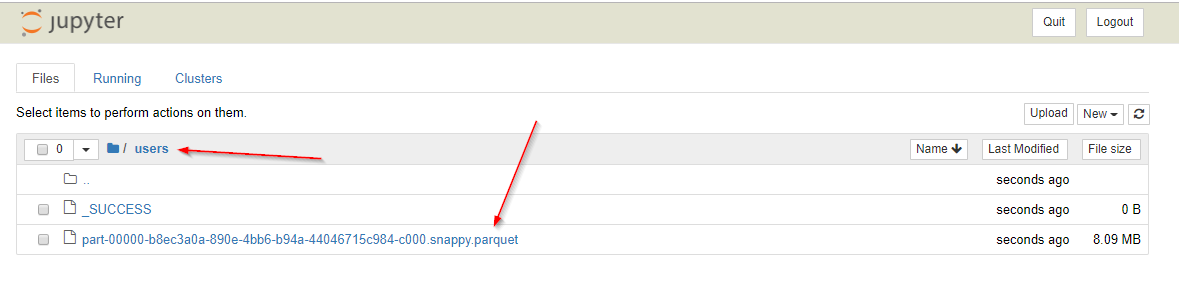

### **Answer**:  The default save format is "parquet".

13\. Each "business" type of records has a `schools` field that lists the schools near the business. Find (and display) the top 5 schools by the number of businesses that list the school. The resulting dataframe should have two fields (`school`,`num_biz`), e.g.

```
+--------------------------------------+-------+
|school                                |num_biz|
+--------------------------------------+-------+
|University of Minnesota, twin cities  |567    |
|St Thomas                             |300    |
...
```

You should report/explain all steps leading to your final outcomes.



### A. Filter on "business" type using the original *yelp* DataFrame and create a new DataFrame labeled *bizDF*.  My variable names aren't the most creative but they do the job :) .

* Cache the DataFrame for faster reading.

In [33]:
bizDF = yelpDF.filter(yelpDF.type == 'business')
bizDF.cache()

DataFrame[average_stars: double, business_id: string, categories: array<string>, city: string, date: string, full_address: string, latitude: double, longitude: double, name: string, neighborhoods: array<string>, open: boolean, photo_url: string, review_count: bigint, review_id: string, schools: array<string>, stars: double, state: string, text: string, type: string, url: string, user_id: string, votes: struct<cool:bigint,funny:bigint,useful:bigint>]

### B. Import sql functions for the next step of analysis.  Explode the *schools* column and do a distinct to see how many schools are in the bizDF DataFrame.

In [34]:
import pyspark.sql.functions as f

In [35]:
distinct_schools = bizDF.select(f.explode(bizDF.schools)).distinct().orderBy("col").show(50, truncate = False)

+------------------------------------------+
|col                                       |
+------------------------------------------+
|Brown University                          |
|California Institute of Technology        |
|California Polytechnic State University   |
|Carnegie Mellon University                |
|Columbia University                       |
|Cornell University                        |
|Georgia Institute of Technology           |
|Harvard University                        |
|Harvey Mudd College                       |
|Massachusetts Institute of Technology     |
|Princeton University                      |
|Purdue University                         |
|Rensselaer Polytechnic Institute          |
|Rice University                           |
|Stanford University                       |
|University of California - Los Angeles    |
|University of California - San Diego      |
|University of California at Berkeley      |
|University of Illinois - Urbana-Champaign |
|Universit

### C. A lot of steps to go through here, so I will take them one at a time:

1. Do a SELECT (first we explode the *schools* column so that we get the actual school name instead of the array Struct) on *schools* and *business_id* so we can get each school and their associated business id. In this step we rename the column *col* to *school* for better readability.
2. Do a groupBy on *school* so we can gather them together.
3. Do a __count()__ so that we can get a count of the number of business ids associated with the school
4. Rename the *count* column to *num_biz* as per the instructions and for readability.
5. Do an orderBy the *num_biz* and set it to ascending = False so that we start in Descending order.
6. Save this to a new DataFrame labeled *schools_count*

In [36]:
schools_countDF = bizDF.select(f.explode(bizDF.schools), "business_id").withColumnRenamed("col", "school") \
    .groupBy("school") \
    .count() \
    .withColumnRenamed("count", "num_biz") \
    .orderBy("num_biz", ascending = False)

### D. 7. Show the first five records of output, the top 5 schools by the number of businesses that list the school.

* Harvard University, 1000
* MIT, 1000
* UCLA, 500
* UC-Berkeley, 500
* Carnegie Mellon, 500

In [37]:
schools_countDF.show(5, truncate = False)

+--------------------------------------+-------+
|school                                |num_biz|
+--------------------------------------+-------+
|Harvard University                    |1000   |
|Massachusetts Institute of Technology |1000   |
|University of California - Los Angeles|500    |
|University of California at Berkeley  |500    |
|Carnegie Mellon University            |500    |
+--------------------------------------+-------+
only showing top 5 rows

